# I. PERKENALAN

Nama : Gheddi

Batch : RMT-022

Objective : This project aims to develop and compare Logistic Regression, Support Vector Machine, and K Nearest Neighbor on Credit Card Default Dataset

# II. IMPORT LIBRARIES

In [1]:
# essentials
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix

# model saving
import joblib
import json

# Colab packages
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
auth.authenticate_user()

print('Authenticated')

project_id = "hactiv8-395804" #GUNAKAN GCP PROJECT-ID KALIAN MASING-MASING
client = bigquery.Client(project=project_id)

Authenticated


### < Conceptual Problem >

1. In logistic regression, the coefficients are critical in deciding the model's result. They aid in determining the anticipated probability and quantifying the link between the independent and dependent variables. The performance and predicted accuracy of the logistic regression model can be enhanced by comprehending the impact of the coefficients.

2. Kernel Function is a method used to take data as input and transform it into the required form of processing data. One example of kernel is linear kernel and its applied when decision boundary of the classes can be drawn with a straight line

3. The elbow method is used to determine the optimal number of clusters in k-means clustering. The elbow method plots the value of the cost function produced by different values of k.

4. the answer of conceptual problem number 4 are on section VII. MODEL EVALUATION.

# III. DATA LOADING

### Create Dataframe

In [3]:
df = client.query('''
SELECT limit_balance, CAST(sex AS INT64) AS sex, CAST(education_level AS INT64) AS education_level, CAST(marital_status AS INT64) AS marital_status, age, pay_0, pay_2, pay_3, pay_4, CAST(pay_5 AS FLOAT64) AS pay_5, CAST(pay_6 AS FLOAT64) AS pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, CAST(default_payment_next_month AS INT64) default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 43934
''').to_dataframe()

In [4]:
# displaying first 10 record
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [5]:
# displaying last 10 record
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


# IV. EDA


In [ ]:
# displaying the columns inside the dataset and it object type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   Int64  
 2   education_level             2965 non-null   Int64  
 3   marital_status              2965 non-null   Int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [ ]:
# checking duplicates
df.duplicated().sum()

1

In [ ]:
# drop duplicated row
df.drop_duplicates(inplace = True)

### < Properties of the Data >

<Axes: xlabel='default_payment_next_month', ylabel='count'>

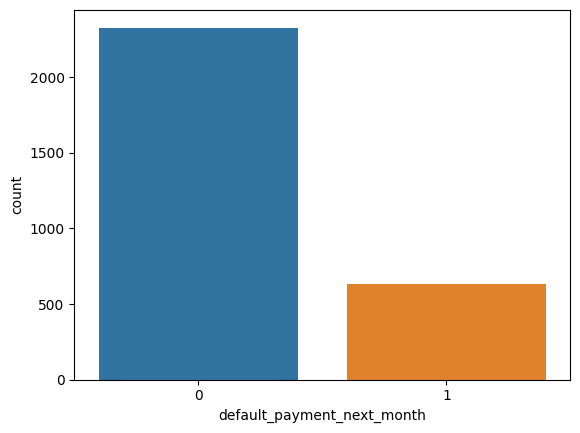

In [ ]:
# checking the balance of the label
sns.countplot(df, x="default_payment_next_month")

array([[<Axes: title={'center': 'limit_balance'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'education_level'}>,
        <Axes: title={'center': 'marital_status'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'pay_0'}>,
        <Axes: title={'center': 'pay_2'}>,
        <Axes: title={'center': 'pay_3'}>,
        <Axes: title={'center': 'pay_4'}>,
        <Axes: title={'center': 'pay_5'}>],
       [<Axes: title={'center': 'pay_6'}>,
        <Axes: title={'center': 'bill_amt_1'}>,
        <Axes: title={'center': 'bill_amt_2'}>,
        <Axes: title={'center': 'bill_amt_3'}>,
        <Axes: title={'center': 'bill_amt_4'}>],
       [<Axes: title={'center': 'bill_amt_5'}>,
        <Axes: title={'center': 'bill_amt_6'}>,
        <Axes: title={'center': 'pay_amt_1'}>,
        <Axes: title={'center': 'pay_amt_2'}>,
        <Axes: title={'center': 'pay_amt_3'}>],
       [<Axes: title={'center': 'pay_amt_4'}>,
        <Axes: title={'c

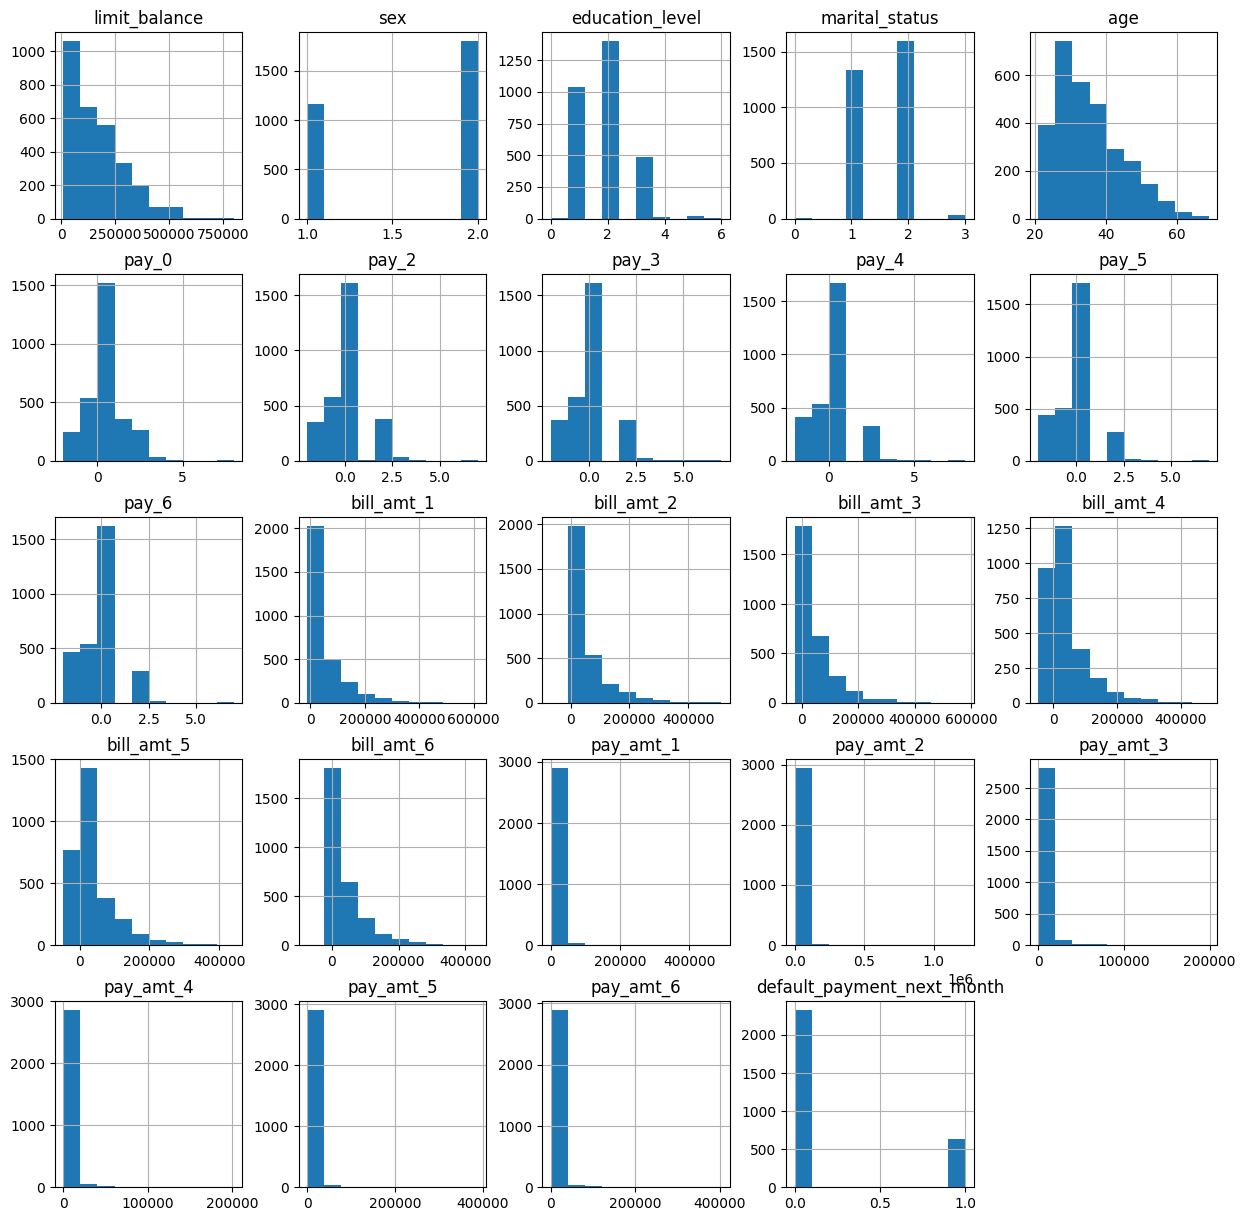

In [ ]:
# display the distribution of all column
df.hist(figsize=(15, 15))

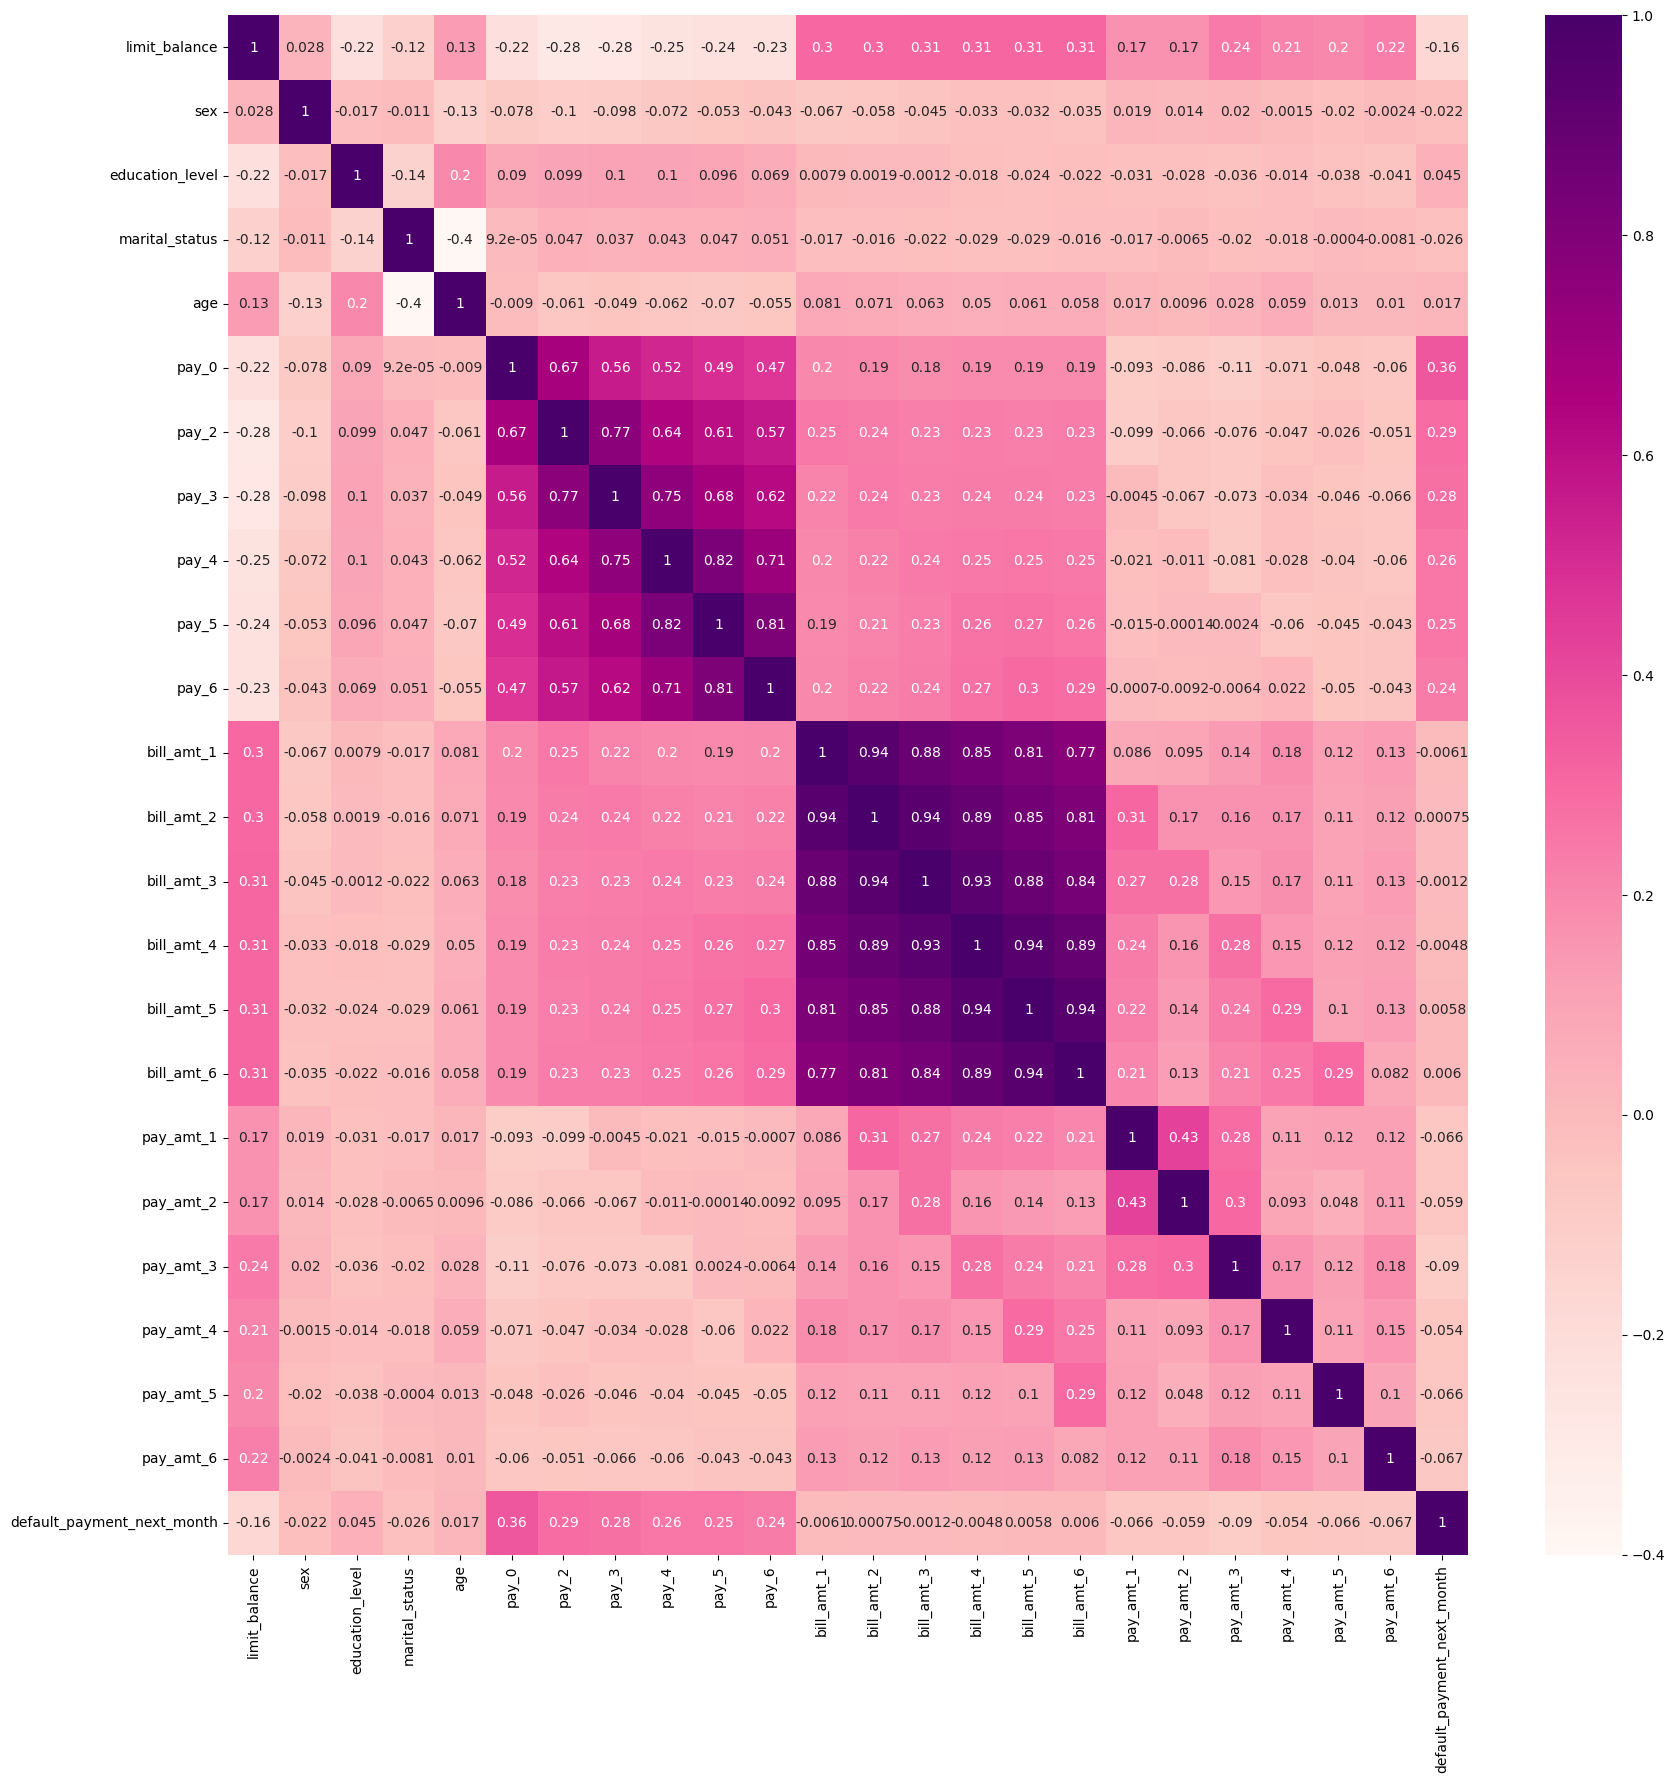

In [ ]:
# looking at correllation strength of numerical variable
df_corr=df.corr(method = 'pearson')

plt.figure(figsize = (20, 20))
sns.heatmap(df_corr,annot=True,cmap='RdPu')
plt.show()

# V. FEATURE ENGINEERING

### < Handling Missing Value >

In [ ]:
# checking missing value
df.isna().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

### < Splitting Train and Test >

In [ ]:
train, test = train_test_split(df, test_size= 0.2,random_state=5)

### < Feature Selection >

Performing statistical test to check the dependency of each feature to target variable using Point Biserial. Setting up P-value threshold to be lower than 0.05.

limit_balance, education_level, pay_0, pay_2, pay_3, pay_4 ,pay_5, pay_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6

In [ ]:
# using point biserial to check the correlation of features(continuous) and target(nominal)
import scipy.stats as stats

limit_balance_corr = stats.pointbiserialr(df['default_payment_next_month'], df['limit_balance'])
sex_corr = stats.pointbiserialr(df['default_payment_next_month'], df['sex'])
education_level_corr = stats.pointbiserialr(df['default_payment_next_month'], df['education_level'])
marital_status_corr = stats.pointbiserialr(df['default_payment_next_month'], df['marital_status'])
age_corr = stats.pointbiserialr(df['default_payment_next_month'], df['age'])
pay_0_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_0'])
pay_2_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_2'])
pay_3_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_3'])
pay_4_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_4'])
pay_5_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_5'])
pay_6_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_6'])
bill_amt_1_corr = stats.pointbiserialr(df['default_payment_next_month'], df['bill_amt_1'])
bill_amt_2_corr = stats.pointbiserialr(df['default_payment_next_month'], df['bill_amt_2'])
bill_amt_3_corr = stats.pointbiserialr(df['default_payment_next_month'], df['bill_amt_3'])
bill_amt_4_corr = stats.pointbiserialr(df['default_payment_next_month'], df['bill_amt_4'])
bill_amt_5_corr = stats.pointbiserialr(df['default_payment_next_month'], df['bill_amt_5'])
bill_amt_6_corr = stats.pointbiserialr(df['default_payment_next_month'], df['bill_amt_6'])
pay_amt_1_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_amt_1'])
pay_amt_2_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_amt_2'])
pay_amt_3_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_amt_3'])
pay_amt_4_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_amt_4'])
pay_amt_5_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_amt_5'])
pay_amt_6_corr = stats.pointbiserialr(df['default_payment_next_month'], df['pay_amt_6'])
default_payment_next_month_corr = stats.pointbiserialr(df['default_payment_next_month'], df['default_payment_next_month'])

In [ ]:
print(f'PB Score limit_balance --> {limit_balance_corr}')
print(f'PB Score sex --> {sex_corr}')
print(f'PB Score education_level --> {education_level_corr}')
print(f'PB Score marital_status --> {marital_status_corr}')
print(f'PB Score age --> {age_corr}')
print(f'PB Score pay_0 --> {pay_0_corr}')
print(f'PB Score pay_2 --> {pay_2_corr}')
print(f'PB Score pay_3 --> {pay_3_corr}')
print(f'PB Score pay_4 --> {pay_4_corr}')
print(f'PB Score pay_5 --> {pay_5_corr}')
print(f'PB Score pay_6 --> {pay_6_corr}')
print(f'PB Score bill_amt_1 --> {bill_amt_1_corr}')
print(f'PB Score bill_amt_2 --> {bill_amt_2_corr}')
print(f'PB Score bill_amt_3 --> {bill_amt_3_corr}')
print(f'PB Score bill_amt_4 --> {bill_amt_4_corr}')
print(f'PB Score bill_amt_5 --> {bill_amt_5_corr}')
print(f'PB Score bill_amt_6 --> {bill_amt_6_corr}')
print(f'PB Score pay_amt_1 --> {pay_amt_1_corr}')
print(f'PB Score pay_amt_2 --> {pay_amt_2_corr}')
print(f'PB Score pay_amt_3 --> {pay_amt_3_corr}')
print(f'PB Score pay_amt_4 --> {pay_amt_4_corr}')
print(f'PB Score pay_amt_5 --> {pay_amt_5_corr}')
print(f'PB Score pay_amt_6 --> {pay_amt_6_corr}')
print(f'PB Score default_payment_next_month --> {default_payment_next_month_corr}')

PB Score limit_balance --> SignificanceResult(statistic=-0.16186761742401715, pvalue=7.492941049828729e-19)
PB Score sex --> SignificanceResult(statistic=-0.021626423049310103, pvalue=0.23917939484018952)
PB Score education_level --> SignificanceResult(statistic=0.044744532739710845, pvalue=0.014842367333264427)
PB Score marital_status --> SignificanceResult(statistic=-0.026192826558125607, pvalue=0.1539695549612546)
PB Score age --> SignificanceResult(statistic=0.016882777320963285, pvalue=0.3581894251966103)
PB Score pay_0 --> SignificanceResult(statistic=0.3571851975034462, pvalue=6.697633068278666e-90)
PB Score pay_2 --> SignificanceResult(statistic=0.28866887431590277, pvalue=5.518119809154069e-58)
PB Score pay_3 --> SignificanceResult(statistic=0.2756083998706877, pvalue=8.167578631392864e-53)
PB Score pay_4 --> SignificanceResult(statistic=0.25564787887904766, pvalue=1.9211653341557177e-45)
PB Score pay_5 --> SignificanceResult(statistic=0.2531612883247307, pvalue=1.438285312627

the selected features from statistical test with threshold of <0.05 :

'limit_balance', 'education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4' ,'pay_5', 'pay_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'

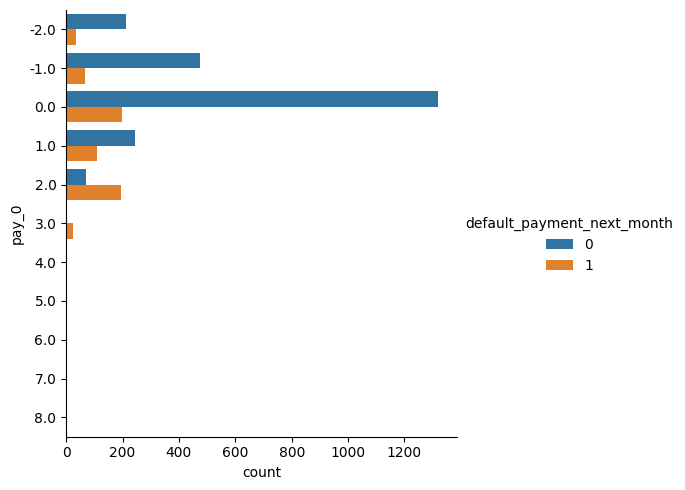

In [6]:
# plotting pay_0 columns
sns.catplot(data=df, y="pay_0", hue='default_payment_next_month', kind="count")

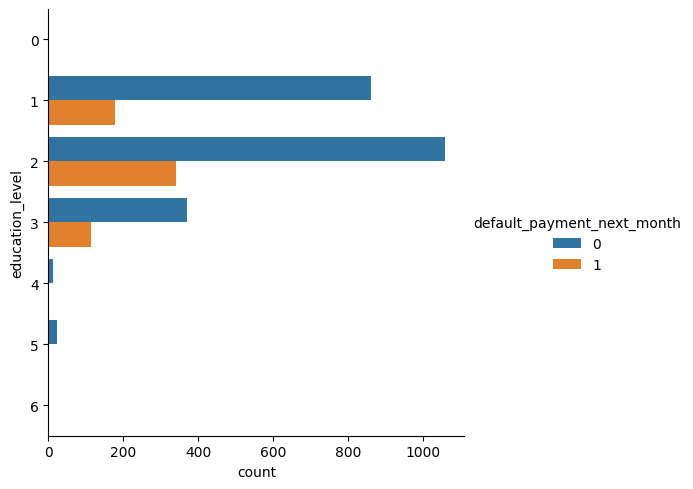

In [9]:
# plotting one of the selected features
sns.catplot(data=df, y="education_level", hue='default_payment_next_month', kind="count")

### < Handling Outlier >

In [ ]:
train[['limit_balance', 'education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4' ,'pay_5', 'pay_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']].describe()

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
count,2371.000000,2371.0,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2.371000e+03,2371.000000,2371.000000,2371.000000,2371.000000
mean,166187.262758,1.843948,0.000422,-0.126529,-0.140447,-0.196542,-0.232813,-0.254745,6492.240405,6.352419e+03,5161.475749,4847.711514,5057.763813,5396.001687
std,126371.184652,0.765903,1.107893,1.169233,1.173590,1.151849,1.145434,1.164549,21246.248501,3.154367e+04,14197.072859,14345.506869,17716.932550,16031.156221
min,10000.000000,0.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,60000.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1067.000000,1.000000e+03,500.000000,346.000000,329.500000,174.500000
50%,140000.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2296.000000,2.158000e+03,2000.000000,1671.000000,1679.000000,1615.000000
75%,240000.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5300.000000,5.000000e+03,4500.000000,4015.500000,4000.000000,4001.500000
max,800000.000000,6.0,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000,493358.000000,1.227082e+06,198748.000000,202076.000000,388071.000000,228300.000000


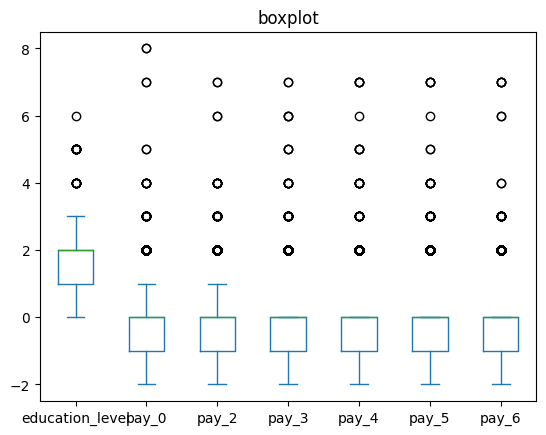

In [ ]:
# Checking the columns with small range.
# Significant amount of outlier on each of these column
# The author did not remove the outlier because the range is small so the outlier is tolerable and not extreme
ax = train[['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4' ,'pay_5', 'pay_6']].plot(kind='box', title='boxplot')
plt.show()

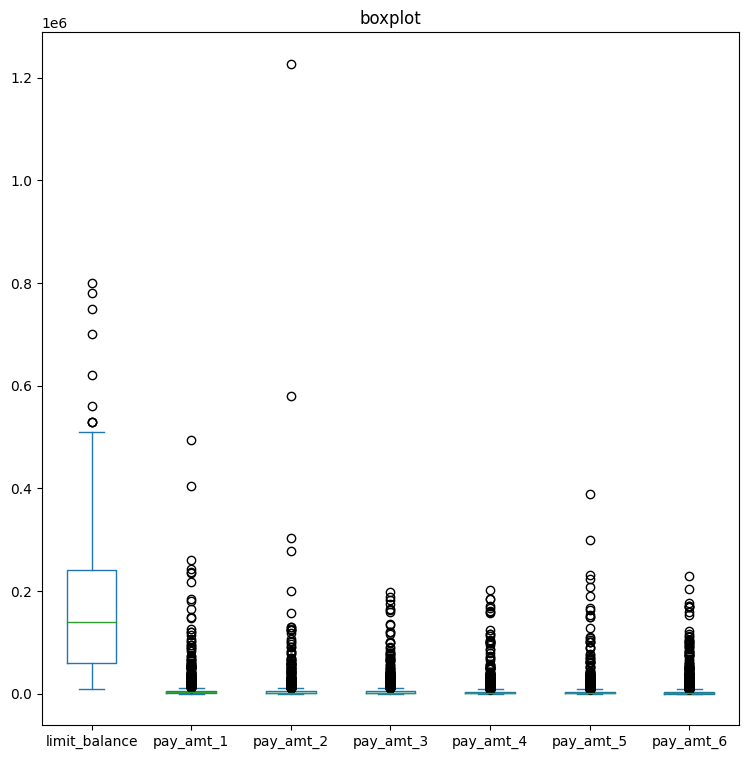

In [ ]:
# Checking outlier on wide numerical range.
# Its laden with outlier, need further analysis
ax = train[['limit_balance','pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']].plot(kind='box', title='boxplot', figsize=(9,9))
plt.show()


In [ ]:
# on this column which represent the other 'pay_amt_n' column, almost a quarter of the data in the train set are outlier
# so the author will keep this in the data
train[train['pay_amt_2'] > 5.000000e+03].value_counts().sum()

585

In [ ]:
# checking how many records act as outlier in the limit balance column
# the outlier on this column is not so many and not too extreme so we'll keep it
fig = px.box(train, y="limit_balance")
fig.show()

### < Splitting Feature and Label >

In [ ]:
X_train = train.drop('default_payment_next_month',axis=1)
Y_train = train['default_payment_next_month']
X_test = test.drop('default_payment_next_month',axis=1)
Y_test = test['default_payment_next_month']

Creating a resampled training data

In [ ]:
X_train_float = X_train
X_train_float[['sex','education_level','marital_status']] = X_train[['sex','education_level','marital_status']].astype(float)

In [ ]:
X_train_resampled, Y_train_resampled = SMOTE(sampling_strategy='minority').fit_resample(X_train_float, Y_train) # Minority Class will have same the same number as the majority class
# X_resampled, y_resampled = SMOTE(sampling_strategy={"Fraud":1000}).fit_resample(X, y) # Minority Class will have 1000 data

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
Y_train_resampled.value_counts()

0    1873
1    1873
Name: default_payment_next_month, dtype: Int64

### < Building Column Transformers >

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2371 entries, 2861 to 2916
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2371 non-null   float64
 1   sex                         2371 non-null   Int64  
 2   education_level             2371 non-null   Int64  
 3   marital_status              2371 non-null   Int64  
 4   age                         2371 non-null   float64
 5   pay_0                       2371 non-null   float64
 6   pay_2                       2371 non-null   float64
 7   pay_3                       2371 non-null   float64
 8   pay_4                       2371 non-null   float64
 9   pay_5                       2371 non-null   float64
 10  pay_6                       2371 non-null   float64
 11  bill_amt_1                  2371 non-null   float64
 12  bill_amt_2                  2371 non-null   float64
 13  bill_amt_3                  23

In [ ]:
train['education_level'].value_counts()

2    1112
1     837
3     393
5      18
4       9
6       1
0       1
Name: education_level, dtype: Int64

In [ ]:
# Because the numerical feature selected contain outliers, the scaling method that'll be used is robust scaler because it can mitigate the effect of outlier
# The Robust Scaler seeks to mitigate the effects of outliers by centering data around the median and by scaling it according to the interquartile range
# citation : The choice of scaling technique matters for classification performance Lucas B.V. de Amorima,b,∗, George D.C. Cavalcantia, Rafael M.O. Cruzc
input_transformer = ColumnTransformer(
  transformers=[
    ("robust_scaler", RobustScaler(), ['limit_balance', 'education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4' ,'pay_5', 'pay_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'])
  ],
  remainder="drop"
)

# VI. MODEL DEFINITION

### < Logistic Regression Model >

Logistic Regression used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables.

advantage : Logistic regression is easier to implement, interpret, and very efficient to train, it can easily extend to multiple classes(multinomial regression) and a natural probabilistic view of class predictions.

disadvantage : If the number of observations is lesser than the number of features, Logistic Regression should not be used, otherwise, it may lead to overfitting, Logistic Regression requires average or no multicollinearity between independent variables.

In [ ]:
model_LOGREG = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("logreg", LogisticRegression())
  ]
)

### < Support Vector Machine Model >

Support vector machine is a supervised learning system and is used for classification and regression problems.

advantages : Support vector machine works comparably well when there is an understandable margin of dissociation between classes, it is more productive in high-dimensional spaces, SVMs have good generalization performance, which means that they are able to classify new, unseen data well.

disadvantages : Support vector machine algorithm is not acceptable for large data sets, and SVMs can be very slow and can consume a lot of memory when the dataset has many features.



In [ ]:
model_SVM = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("svm", SVC())
  ]
)

### K Nearest Neighbor Model

KNN Algorithm is a machine learning algorithm used for classification and regression, where the input is classified by its nearest neighbors in the feature space.

advantages : Simple and Easy to Understand, Non-parametric, Can Handle Large Datasets

disadvantages : Sensitive to Outliers, computationally expensive, requires Good Choice of K.

In [ ]:
model_KNN = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("knn", KNeighborsClassifier())
  ]
)

# VII. MODEL TRAINING

### < Logistic Regression Model Training >

In [ ]:
logreg_param = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

logreg_grid = GridSearchCV(model_LOGREG, param_grid=logreg_param, cv=5)
logreg_grid.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('input processing',
                                        ColumnTransformer(transformers=[('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['limit_balance',
                                                                          'education_level',
                                                                          'pay_0',
                                                                          'pay_2',
                                                                          'pay_3',
                                                                          'pay_4',
                                                                          'pay_5',
                                                                          'pay_6',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_amt_5',
                                                                          'pay_amt_6'])])),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.01, 0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2', 'elasticnet']})

In [ ]:
logreg_grid.best_params_

{'logreg__C': 10, 'logreg__penalty': 'l2'}

In [ ]:
# recreating new model with best parameter
model_LOGREG_tuned = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("logreg", LogisticRegression(penalty = 'l2', C=10))
  ]
)

model_LOGREG_tuned.fit(X_train, Y_train)

Pipeline(steps=[('input processing',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('logreg', LogisticRegression(C=10))])

### < Support Vector Machine Model Training >

In [ ]:
svm_param = {
  'svm__kernel': ['linear','rbf'],
  'svm__C': [0.1, 1, 10],
  'svm__gamma': [1, 0.1, 0.01]
}

svm_grid = GridSearchCV(model_SVM, param_grid=svm_param, cv=5)
svm_grid.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('input processing',
                                        ColumnTransformer(transformers=[('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['limit_balance',
                                                                          'education_level',
                                                                          'pay_0',
                                                                          'pay_2',
                                                                          'pay_3',
                                                                          'pay_4',
                                                                          'pay_5',
                                                                          'pay_6',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_amt_5',
                                                                          'pay_amt_6'])])),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [1, 0.1, 0.01],
                         'svm__kernel': ['linear', 'rbf']})

In [ ]:
svm_grid.best_params_

{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

In [ ]:
# recreating new model with best parameter
model_SVM_tuned = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("svm", SVC(kernel = 'rbf',C = 10, gamma =  0.01))
  ]
)

model_SVM_tuned.fit(X_train, Y_train)

Pipeline(steps=[('input processing',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('svm', SVC(C=10, gamma=0.01))])

### < K Nearest Neighbor Model Training >

In [ ]:
knn_param = {
  'knn__n_neighbors': [4,5,6,7,8,9,10]
}

knn_grid = GridSearchCV(model_KNN, param_grid=knn_param, cv=5)
knn_grid.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('input processing',
                                        ColumnTransformer(transformers=[('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['limit_balance',
                                                                          'education_level',
                                                                          'pay_0',
                                                                          'pay_2',
                                                                          'pay_3',
                                                                          'pay_4',
                                                                          'pay_5',
                                                                          'pay_6',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_amt_5',
                                                                          'pay_amt_6'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [4, 5, 6, 7, 8, 9, 10]})

In [ ]:
knn_grid.best_params_

{'knn__n_neighbors': 8}

In [ ]:
# recreating new model with best parameter
model_KNN_tuned = Pipeline(
  steps=[
    ("input processing", input_transformer),
    ("knn", KNeighborsClassifier(n_neighbors = 8))
  ]
)

model_KNN_tuned.fit(X_train, Y_train)

Pipeline(steps=[('input processing',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('knn', KNeighborsClassifier(n_neighbors=8))])

# VIII. MODEL EVALUATION

### < Evaluation Metric for Classification Problem >

1. Accuracy : Accuracy measure the total correct prediction divide by the total number of predictions a model make. Accuracy can be misleading in imbalanced dataset. So its only viable on when the dataset is balanced

2. Precision : a metric that measures how often a model correctly predicts the positive class. It's used if we're looking to minimize False Positive to be as low as possible. Example of minimizing false positive is, when you dont want a model to misclassify a non employee as employee that can sneak inside a private building

3. Recall :  a metric that measures how often a model correctly identifies positive instances (True Positive) from all the actual positive samples in the dataset. It's used if we're looking to minimize False Negative to be as low as possible. Example of minimizing false negative is, when you dont want the model to falsely identify someone as healty but he/she actually carry a disease.

4. F1 Score : harmonic mean of precision and recall. The metric is useful if we were looking to minimize false positive and false negative at the same time.

* Accuracy, Precision, Recall, and F1 Score have scale : 0 - 1. The higher the value, the better.

### < Logistic Regression Model Evaluation >

In [ ]:
Y_train_pred = model_LOGREG_tuned.predict(X_train)
Y_test_pred = model_LOGREG_tuned.predict(X_test)

print('Training Report for Logistic Regression Model')
print(classification_report(Y_train, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for Logistic Regression Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for Logistic Regression Model
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      1873
         1.0       0.75      0.32      0.45       498

    accuracy                           0.84      2371
   macro avg       0.80      0.65      0.68      2371
weighted avg       0.82      0.84      0.81      2371

------------------------------------------------------
Testing Report for Logistic Regression Model
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       456
         1.0       0.76      0.27      0.40       137

    accuracy                           0.81       593
   macro avg       0.79      0.62      0.64       593
weighted avg       0.80      0.81      0.77       593



***Interpreting The Logistic Regression Model Evaluation Result***

In credit card default prediction problem, the author will focus on the goal to build a model with highest capability at predicting people who's actually going to default, because defaulters pose a high financial loss probability.
this is the case when we need to minimize false negative to be as low as possible so we need to focus on the recall metric.

the recall score of Logistic Regression model for class '1' (people who default) are considerably low for both the train and test set at below 35%. This clearly shows that the model will only be correct at predicting people who're going to default only around 27 out of 100 times by looking at the recall at test set.

Furthermore there's a visible decline of recall on the test set about 5% decline from the train set. This is indicating the Logistic Regression model doesnt generalize well to new data.

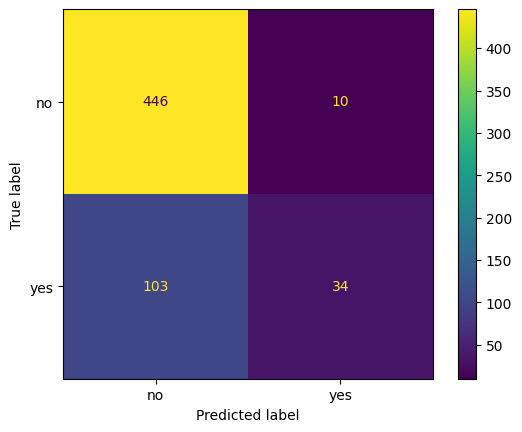

In [ ]:
#
Y_test_pred = model_LOGREG_tuned.predict(X_test)
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()
plt.show()

### < Support Vector Machine Model Evaluation >

In [ ]:
Y_train_pred = model_SVM_tuned.predict(X_train)
Y_test_pred = model_SVM_tuned.predict(X_test)

print('Training Report for SVM Model')
print(classification_report(Y_train, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for SVM Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for SVM Model
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1873
         1.0       0.79      0.41      0.54       498

    accuracy                           0.85      2371
   macro avg       0.82      0.69      0.72      2371
weighted avg       0.84      0.85      0.83      2371

------------------------------------------------------
Testing Report for SVM Model
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89       456
         1.0       0.71      0.32      0.44       137

    accuracy                           0.81       593
   macro avg       0.77      0.64      0.66       593
weighted avg       0.80      0.81      0.78       593



***Interpreting The SVM Evaluation Result***

In credit card default prediction problem, the author will focus on the goal to build a model with highest capability at predicting people who's actually going to default, because defaulters pose a high financial loss probability.
this is the case when we need to minimize false negative to be as low as possible so we need to focus on the recall metric.

the recall score of Support Vector model for class '1' are considerably low for both the train and test set at below 45%. This clearly shows that the model will only be correct at predicting people who're going to default only around 3 out of 10 times by looking at the recall at test set.

Furthermore there's a visible decline of recall on the test set about 9% decline from the train set. This is indicating the Support Vector model doesnt generalize well to new data.

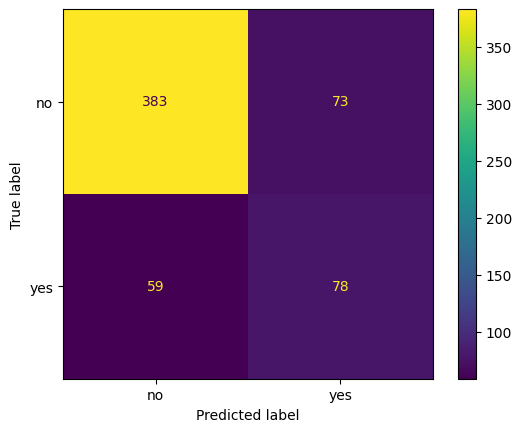

In [ ]:
Y_test_pred = model_SVM_tuned.predict(X_test)
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()
plt.show()

### < K Nearest Neighbor Model Evaluation >

In [ ]:
Y_train_pred = model_KNN_tuned.predict(X_train)
Y_test_pred = model_KNN_tuned.predict(X_test)

print('Training Report for KNN Model')
print(classification_report(Y_train, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for KNN Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for KNN Model
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      1873
         1.0       0.77      0.35      0.48       498

    accuracy                           0.84      2371
   macro avg       0.81      0.66      0.69      2371
weighted avg       0.83      0.84      0.82      2371

------------------------------------------------------
Testing Report for KNN Model
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       456
         1.0       0.72      0.28      0.40       137

    accuracy                           0.81       593
   macro avg       0.77      0.62      0.64       593
weighted avg       0.79      0.81      0.77       593



***Interpreting The KNN Evaluation Result***

In credit card default prediction problem, the author will focus on the goal to build a model with highest capability at predicting people who's actually going to default, because defaulters pose a high financial loss probability.
this is the case when we need to minimize false negative to be as low as possible so we need to focus on the recall metric.

the recall score of Support Vector model for class '1' are considerably low for both the train and test set at below 40%. This clearly shows that the model will only be correct at predicting people who're going to default only around 28 out of 100 times by looking at the recall at test set.

Furthermore there's a visible decline of recall on the test set about 7% decline from the train set. This is indicating the Support Vector model doesnt generalize well to new data.

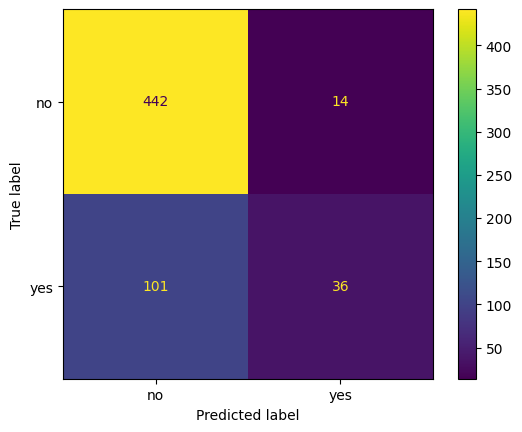

In [ ]:
Y_test_pred = model_KNN_tuned.predict(X_test)
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()
plt.show()

### < Checking the performance of the best model with oversampled data >

In [ ]:
model_SVM_tuned.fit(X_train_resampled, Y_train_resampled)

Pipeline(steps=[('input processing',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['limit_balance',
                                                   'education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'pay_amt_1', 'pay_amt_2',
                                                   'pay_amt_3', 'pay_amt_4',
                                                   'pay_amt_5',
                                                   'pay_amt_6'])])),
                ('svm', SVC(C=10, gamma=0.01))])

In [ ]:
Y_train_pred = model_SVM_tuned.predict(X_train)
Y_test_pred = model_SVM_tuned.predict(X_test)

print('Training Report for SVM Model')
print(classification_report(Y_train, Y_train_pred))
print('------------------------------------------------------')

print('Testing Report for SVM Model')
print(classification_report(Y_test, Y_test_pred))

Training Report for SVM Model
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      1873
         1.0       0.56      0.63      0.59       498

    accuracy                           0.82      2371
   macro avg       0.73      0.75      0.74      2371
weighted avg       0.83      0.82      0.82      2371

------------------------------------------------------
Testing Report for SVM Model
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       456
         1.0       0.52      0.57      0.54       137

    accuracy                           0.78       593
   macro avg       0.69      0.70      0.70       593
weighted avg       0.79      0.78      0.78       593



***Oversampled data and it's impact on model performance***

the recall of the model with oversampled data has shown great impact at helping the model to better learn from the data.

compared to the performance of the model with original data, the performance of the new model has improved significantly showing an increase of 22 percent on the train set, and 25% increase on the test set. Additionaly the generalization performance decline from the train set is only 8% which is 1% lower than the performance of the model with original data.

### < Overall Analysis >



1.   We have trained the model and understand the weakness and strength of each model.
2.   After performing hyperparameter tuning on each model, SVM come out to perform better than the other 2.
3.   Use of oversampling method like SMOTE significantly help the model to learn better on the train set thus improving its generalization ability on the test set.
4.   Unfortunately the best model that has been tuned and fed with oversampled data still not yielding a reliable result that can be applied with business. The generalization power of the best model with oversampled data is only around 57% which mean the model is only capable of making around only 57 correct prediction out of 100 prediction.



# IX. MODEL SAVING

In [ ]:
# saving the model, scaler, and encoder
with open('model_svm.pkl', 'wb') as file_1:
  joblib.dump(model_SVM_tuned, file_1)

with open('model_transformer.pkl', 'wb') as file_2:
  joblib.dump(input_transformer, file_2)

# X. MODEL INFERENCE

In [ ]:
# loading model
with open('model_svm.pkl', 'rb') as file_1:
  svm = joblib.load(file_1)

with open('model_transformer.pkl', 'rb') as file_2:
  transformer = joblib.load(file_2)

In [ ]:
test_dict = df.iloc[2292:2293].to_dict('records')
test_dict

In [ ]:
# making dummmy data for inference
test_data = pd.DataFrame({
  'limit_balance': [50000.0],
  'sex': [1],
  'education_level': [1],
  'marital_status': [1],
  'age': [47.0],
  'pay_0': [0.0],
  'pay_2': [0.0],
  'pay_3': [0.0],
  'pay_4': [0.0],
  'pay_5': [0.0],
  'pay_6': [0.0],
  'bill_amt_1': [47695.0],
  'bill_amt_2': [49550.0],
  'bill_amt_3': [51636.0],
  'bill_amt_4': [53561.0],
  'bill_amt_5': [53283.0],
  'bill_amt_6': [53057.0],
  'pay_amt_1': [2657.0],
  'pay_amt_2': [2743.0],
  'pay_amt_3': [2668.0],
  'pay_amt_4': [1712.0],
  'pay_amt_5': [1762.0],
  'pay_amt_6': [1894.0],
  'default_payment_next_month': [0]
  }
)

In [ ]:
# making prediction on new data
svm.predict(test_data)

array([0.])

# XI. PENGAMBILAN KESIMPULAN

1. From model evaluation, it can be inferred that SVM have better performance in classifying this data than Logistic Regression or KNN.

2. From the classification report and evaluation metric, it can be inferred that this model is still less reliable to be applied in business. It would be detrimental for business to utilize a model with a mediocre performance.

3. Performing Oversampling method such as SMOTE on imbalanced data significantly improve the model ability to learn from that data

3. for further improvement, the author suggest to feature engineer new variables with better predictive power and to utilize a better classification algorithm than Logistic Regression, SVM, and KNN.